<a href="https://colab.research.google.com/github/ggp6101/DSCI644_Group1/blob/main/DSCI644_Notebook01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Initial exploration and preparation of the Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Change the line below for your path to the .csv file.
data = pd.read_csv('drive/Shared drives/DSCI644_Group1/Code_review.csv')
data.shape

Mounted at /content/drive


(3838, 11)

In [ ]:
data.head()

,id,url,subject,description,Category,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,openstack%2Frally~master~I9da0124d5a644fccb6e6...,https://review.opendev.org/240219,Refactoring log utils,Refactoring log utils * Moved log functions f...,testing,NaN,NaN,NaN,NaN,NaN,NaN
1,openstack%2Frally~master~I9da0124d5a644fccb6e6...,https://review.opendev.org/240219,Refactoring log utils,Refactoring log utils * Moved log functions f...,objective,NaN,NaN,NaN,NaN,NaN,NaN
2,zuul%2Fzuul~master~Icbe206db6bcbaaf78a3d89997f...,https://review.opendev.org/223063,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing ...,testing,NaN,NaN,NaN,NaN,NaN,NaN
3,zuul%2Fzuul~master~Icbe206db6bcbaaf78a3d89997f...,https://review.opendev.org/223063,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing ...,objective,NaN,NaN,NaN,NaN,NaN,NaN
4,openstack%2Fhorizon~master~I5d2272a0abb521ddb9...,https://review.opendev.org/142839,Refactor project instance test,Refactor project instance test Refactoring th...,testing,NaN,NaN,NaN,NaN,NaN,NaN


### We only need the subject, descripton, and category columns. The goal of the project is to predict the category from the subject and description.

In [ ]:
# Select subject, description, and category columns. Drop any rows with NaNs.
data = data[["subject","description","Category"]].copy()
data.rename(columns = {'Category':'category'}, inplace = True)
print(data.shape)
data = data.dropna()
print(data.shape)

(3838, 3)
(3836, 3)


In [ ]:
data.category.value_counts()

objective      1549
quality         937
testing         745
integration     440
refactoring     165
Name: category, dtype: int64

### There are five different categories. These five categories are also not balanced, so this will be a multiclass classification problem with imbalanced data. Note that these counts match the counts given in our Excel file, so that is good.

### How many UNIQUE subject/description pairs are there ?

In [ ]:
subjects_descriptions = np.array(data[["subject","description"]]).astype('str')
uniquearr=np.unique(subjects_descriptions, axis=0)
uniquearr.shape

(1706, 2)

### There are 3836 lines in the file, but only 1706 unique subject/description pairs. This means that subject/description pairs can be assigned multiple categories; for example, to both 'testing' and 'objective'. So this will also be a multi-label classification problem, so something like this article might be a helpful guide: [Article on multi-label classification](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)

### Now make a dataframe where we add a column of lists containing each of the categories that a description has been assigned to.

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

uniquedf = pd.DataFrame(uniquearr, columns = ['subject','description'])
uniquedf['category_list'] = np.empty((len(uniquedf), 0)).tolist()

for i in range(len(uniquedf)):
  mask1 = (data.subject == uniquedf.subject[i])
  mask2 = (data.description == uniquedf.description[i])
  stage = data[mask1 & mask2]
  uniquedf.category_list[i].extend(stage.category)
uniquedf.tail()

,subject,description,category_list
1701,xenapi: refactor spawn to prep for more code s...,xenapi: refactor spawn so more code can be sha...,"[objective, quality, objective]"
1702,xenapi: refactor volumeops attach,xenapi: refactor volumeops attach Refactor th...,"[quality, objective]"
1703,xenapi: refactor: move RawTGZImage to common,xenapi: refactor: move RawTGZImage to common ...,"[quality, objective, objective]"
1704,xenapi: refactor: move UpdateGlanceImage to co...,xenapi: refactor: move UpdateGlanceImage to co...,"[refactoring, objective, objective]"
1705,zmq: Refactor test case shared code,zmq: Refactor test case shared code A number ...,"[testing, quality, objective]"


### Now add a column for each category. This column will count how many times a given category was assigned to that description.

In [ ]:
features = ['objective', 'quality', 'testing', 'integration', 'refactoring']
uniquedf[features] = np.nan

for i in range(len(uniquedf)):
  for x in features:
    uniquedf[x][i] = uniquedf.category_list[i].count(x)

uniquedf = uniquedf.astype({"subject":'string', "description":'string'})
uniquedf = uniquedf.astype({"objective":'int', "quality":'int', "testing":'int', "integration":'int', "refactoring":'int'})
uniquedf.tail()

,subject,description,category_list,objective,quality,testing,integration,refactoring
1701,xenapi: refactor spawn to prep for more code s...,xenapi: refactor spawn so more code can be sha...,"[objective, quality, objective]",2,1,0,0,0
1702,xenapi: refactor volumeops attach,xenapi: refactor volumeops attach Refactor th...,"[quality, objective]",1,1,0,0,0
1703,xenapi: refactor: move RawTGZImage to common,xenapi: refactor: move RawTGZImage to common ...,"[quality, objective, objective]",2,1,0,0,0
1704,xenapi: refactor: move UpdateGlanceImage to co...,xenapi: refactor: move UpdateGlanceImage to co...,"[refactoring, objective, objective]",2,0,0,0,1
1705,zmq: Refactor test case shared code,zmq: Refactor test case shared code A number ...,"[testing, quality, objective]",1,1,1,0,0


### Check that the sum is still what we had before from the original data frame and from the Excel file.

In [ ]:
uniquedf[features].sum(axis=0)

objective      1549
quality         937
testing         745
integration     440
refactoring     165
dtype: int64

  ### Note from the data frame above that some desciptions have the same label applied more than once. This is probably because in the original paper, each of these categories had sub-categories that could be assigned. So a description might be assigned to more than one sub-category within the 'objective' category, say. We can just set numbers greater than one to one, since we are just interested in if a description belongs to that category or not.

In [ ]:
for x in features:
  uniquedf.loc[uniquedf[x] > 1, x] = 1

uniquedf.tail()

,subject,description,category_list,objective,quality,testing,integration,refactoring
1701,xenapi: refactor spawn to prep for more code s...,xenapi: refactor spawn so more code can be sha...,"[objective, quality, objective]",1,1,0,0,0
1702,xenapi: refactor volumeops attach,xenapi: refactor volumeops attach Refactor th...,"[quality, objective]",1,1,0,0,0
1703,xenapi: refactor: move RawTGZImage to common,xenapi: refactor: move RawTGZImage to common ...,"[quality, objective, objective]",1,1,0,0,0
1704,xenapi: refactor: move UpdateGlanceImage to co...,xenapi: refactor: move UpdateGlanceImage to co...,"[refactoring, objective, objective]",1,0,0,0,1
1705,zmq: Refactor test case shared code,zmq: Refactor test case shared code A number ...,"[testing, quality, objective]",1,1,1,0,0


In [ ]:
#See what the counts are now that duplicates have been removed, and also check what the class balance is.
print(uniquedf[features].sum(axis=0))
print(uniquedf[features].sum(axis=0)/len(uniquedf))

objective      1327
quality         917
testing         740
integration     433
refactoring     162
dtype: int64
objective      0.777843
quality        0.537515
testing        0.433763
integration    0.253810
refactoring    0.094959
dtype: float64


### Now we can delete the category_list column to complete the initial preparation of our cleaned dataset.

In [ ]:
cleaned_df = uniquedf.drop(['category_list'], axis=1)
cleaned_df.head()

,subject,description,objective,quality,testing,integration,refactoring
0,(WIP) Refactor for better connection testing,(WIP) Refactor for better connection testing ...,1,0,1,0,0
1,(refactor) Refactor Ansible for standard-conta...,(refactor) Refactor Ansible for standard-conta...,1,1,0,0,0
2,- switch to testtools - remove pep8 warnings -...,- switch to testtools - remove pep8 warnings -...,1,0,1,1,0
3,A minor refactor in wsgi.py,A minor refactor in wsgi.py A minor refactor ...,1,0,0,0,1
4,A minor refactor in wsgi.py,a minor refactor in wsgi.py a minor refactor ...,1,0,0,0,1


### This should now be a cleaned and prepared data frame, ready for Phase 2. But first, we should check for any correlations among the five categories.

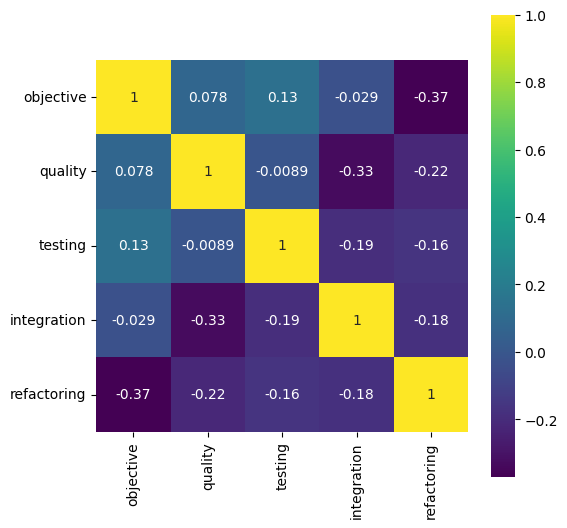

In [ ]:
import seaborn as sns
plt.figure(figsize = (6,6))
sns.heatmap(cleaned_df[features].corr(), cmap='viridis', annot=True, square=True)
plt.show()

### There are no strong correlations. The highest magnitude is 0.37, which is considered a low correlation.

### So now we can, for example, train a binary classifier for each of these five categories. So based on the review subject and/or the review description does the review belong to the 'objective' category, or not? Does it belong to the 'quality' category, or not?, etc.

# Step 2: Visualize common subject and description words

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

stop_set = set(stopwords.words('english')+ list(string.punctuation))
snowball = SnowballStemmer('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def process_text(textcolumn):
  concat = textcolumn.str.cat(sep=' ')
  tokens = word_tokenize(concat.lower())
  tokens = [w for w in tokens if not w in stop_set]
  stem = []
  for t in tokens:
    stem.append(snowball.stem(t))
  stem = [i for i in stem if i != 'refactor'] #This was a selection criteria, so will be in every item by definition, so provides no information.
  vocab = set(stem)
  return (stem, vocab)

In [ ]:
subject_stem, subject_vocab = process_text(cleaned_df.subject)

print('Total number of subject words:', len(subject_stem))
print('Size of subject voabulary:', len(subject_vocab))

Total number of subject words: 6370
Size of subject voabulary: 1891


In [ ]:
description_stem, description_vocab = process_text(cleaned_df.description)

print('Total number of description words:', len(description_stem))
print('Size of description voabulary:', len(description_vocab))

Total number of description words: 60377
Size of description voabulary: 9208


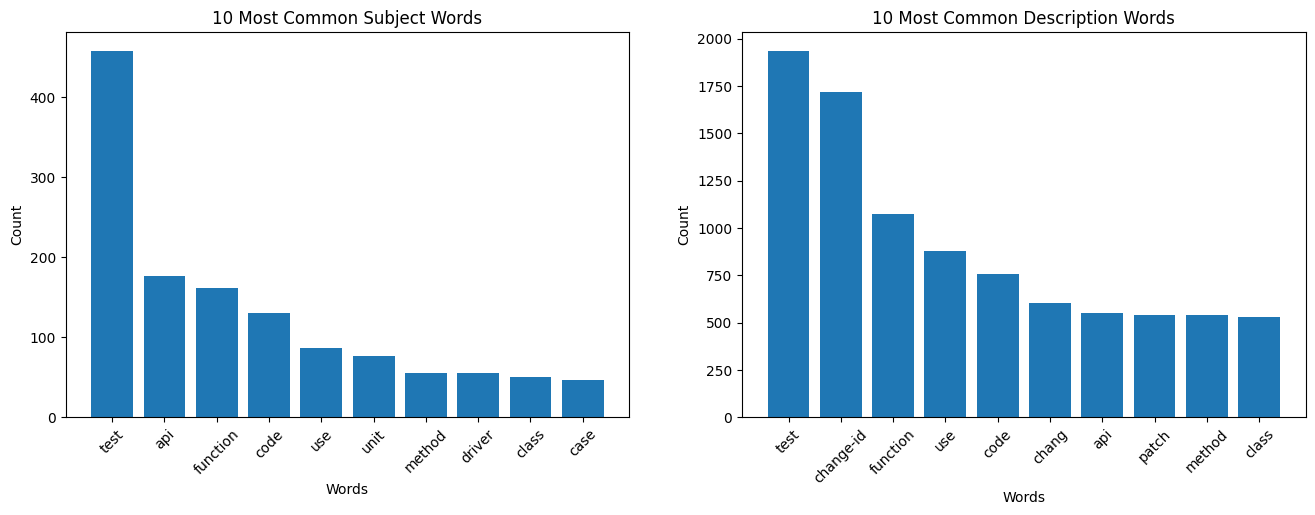

In [ ]:
subject_freq = nltk.FreqDist(subject_stem)
description_freq = nltk.FreqDist(description_stem)

subject_words, subject_frequencies = zip(*subject_freq.most_common(10))
desc_words, desc_frequencies = zip(*description_freq.most_common(10))

fig, axs = plt.subplots(1,2, figsize=(16, 5))

axs[0].bar(subject_words, subject_frequencies)
axs[0].set_title('10 Most Common Subject Words')
axs[0].set_xticks(subject_words)
axs[0].set_xticklabels(subject_words, rotation=45)

axs[1].bar(desc_words, desc_frequencies)
axs[1].set_title('10 Most Common Description Words')
axs[1].set_xticks(desc_words)
axs[1].set_xticklabels(desc_words, rotation=45)

for ax in axs:
    ax.set_xlabel('Words')
    ax.set_ylabel('Count')

plt.show()

# Step 3: Train Binary Classifiers Based on TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics  import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

In [ ]:
def vectorize_text_columns (Xdataframe, y):

  X_train, X_test, y_train, y_test = train_test_split(Xdataframe, y, random_state=123)
  #X_train, X_test, y_train, y_test = train_test_split(Xdataframe, y)

  tfidf_vect = TfidfVectorizer()
  X_train_vect1 = tfidf_vect.fit_transform(X_train.subject)
  X_test_vect1 = tfidf_vect.transform(X_test.subject)

  #print(X_train_vect1.shape)
  #print(X_train_vect1[0][0:3])
  #print(tfidf_vect.get_feature_names_out())

  tfidf_vect2 = TfidfVectorizer()
  X_train_vect2 = tfidf_vect2.fit_transform(X_train.description)
  X_test_vect2 = tfidf_vect2.transform(X_test.description)

  #print(X_train_vect2.shape)
  #print(X_train_vect2[0][0:3])
  #print(tfidf_vect2.get_feature_names_out())

  return(X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test)

### The paper by Herbold et al. (2020) generates a combined probability from (subject probability + description probability) / 2, and then classifies based on the combined probability, so we use that approach below. This function reports the accuracies of the subject classifications, the description classifications, and the combined classifications. It also reports precision, recall, and f1 score for each of these.

In [ ]:
def predict_and_score(classifier1, x_test1, classifier2, x_test2, y_test):

  predicted_prob_subj = classifier1.predict_proba(x_test1)
  predicted_bin_subj = classifier1.predict(x_test1)
  print('Subject accuracy:', accuracy_score(y_test,predicted_bin_subj))
  print('Subject AUC score:',roc_auc_score(y_test, predicted_prob_subj[:,1]))
  print('Subject precision, recall, f1 score:',precision_recall_fscore_support(y_test,predicted_bin_subj, average='binary', pos_label=1)[0:3])
  print()

  predicted_prob_desc = classifier2.predict_proba(x_test2)
  predicted_bin_desc = classifier2.predict(x_test2)
  print('Description accuracy:', accuracy_score(y_test,predicted_bin_desc))
  print('Description AUC score:',roc_auc_score(y_test, predicted_prob_desc[:,1]))
  print('Description precision, recall, f1 score:', precision_recall_fscore_support(y_test,predicted_bin_desc, average='binary', pos_label=1)[0:3])
  print()

  predicted_prob_comb = (predicted_prob_subj + predicted_prob_desc)/2.0
  predicted_bin_comb = np.argmax(predicted_prob_comb, axis=1)
  print('Combined accuracy:', accuracy_score(y_test,predicted_bin_comb))
  print('Combined AUC score:',roc_auc_score(y_test, predicted_prob_comb[:,1]))
  print('Combined precision, recall, f1 score:', precision_recall_fscore_support(y_test,predicted_bin_comb, average='binary', pos_label=1)[0:3])
  print()

  return (predicted_bin_subj, predicted_bin_desc, predicted_bin_comb, predicted_prob_subj, predicted_prob_desc, predicted_prob_comb)


### Function to plot the confusion matrices for the subject classifier, the description classifier, and the combined classifier.

In [ ]:
def confusion_plot(y_test, predicted_bin_subj, predicted_bin_desc, predicted_bin_comb):

  from sklearn.metrics import ConfusionMatrixDisplay

  fig, axs = plt.subplots(1,3, figsize=(18, 5))

  ConfusionMatrixDisplay.from_predictions(y_test, predicted_bin_subj, ax=axs[0])
  ConfusionMatrixDisplay.from_predictions(y_test, predicted_bin_desc, ax=axs[1])
  ConfusionMatrixDisplay.from_predictions(y_test, predicted_bin_comb, ax=axs[2])

  axs[0].set_title('Subject')
  axs[1].set_title('Description')
  axs[2].set_title('Combined')

  plt.show()

### Function for plotting ROC curves.

In [ ]:
def roc_plot(y_test, predicted_prob_subj, predicted_prob_desc, predicted_prob_comb, name):

  from sklearn.metrics import RocCurveDisplay

  fig, axs = plt.subplots(1,3, figsize=(16, 4))

  RocCurveDisplay.from_predictions(y_test, predicted_prob_subj[:,1], ax=axs[0], name=name)
  RocCurveDisplay.from_predictions(y_test, predicted_prob_desc[:,1], ax=axs[1], name=name)
  RocCurveDisplay.from_predictions(y_test, predicted_prob_comb[:,1], ax=axs[2], name=name)

  axs[0].set_title('Subject')
  axs[1].set_title('Description')
  axs[2].set_title('Combined')

  plt.show()

In [ ]:
def fit_naive_bayes(X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test):

  from sklearn.naive_bayes import ComplementNB

  clf1 = ComplementNB().fit(X_train_vect1, y_train)
  clf2 = ComplementNB().fit(X_train_vect2, y_train)

  predict_subj, predict_desc, predict_comb, predict_prob_subj, predict_prob_desc, predict_prob_comb = predict_and_score(clf1, X_test_vect1, clf2, X_test_vect2, y_test)

  confusion_plot(y_test, predict_subj, predict_desc, predict_comb)
  roc_plot(y_test, predict_prob_subj, predict_prob_desc, predict_prob_comb, 'Naive Bayes')


In [ ]:
def fit_logistic_regression(X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test):

  from sklearn.linear_model import LogisticRegression

  clf1 = LogisticRegression(class_weight='balanced').fit(X_train_vect1, y_train)
  clf2 = LogisticRegression(class_weight='balanced').fit(X_train_vect2, y_train)

  predict_subj, predict_desc, predict_comb, predict_prob_subj, predict_prob_desc, predict_prob_comb = predict_and_score(clf1, X_test_vect1, clf2, X_test_vect2, y_test)

  confusion_plot(y_test, predict_subj, predict_desc, predict_comb)
  roc_plot(y_test, predict_prob_subj, predict_prob_desc, predict_prob_comb, 'Logistic Regression')

In [ ]:
def fit_random_forest(X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test):

  from sklearn.ensemble import RandomForestClassifier

  clf1 = RandomForestClassifier(class_weight='balanced', random_state=123).fit(X_train_vect1, y_train)
  clf2 = RandomForestClassifier(class_weight='balanced', random_state=123).fit(X_train_vect2, y_train)

  predict_subj, predict_desc, predict_comb, predict_prob_subj, predict_prob_desc, predict_prob_comb = predict_and_score(clf1, X_test_vect1, clf2, X_test_vect2, y_test)

  confusion_plot(y_test, predict_subj, predict_desc, predict_comb)
  roc_plot(y_test, predict_prob_subj, predict_prob_desc, predict_prob_comb, 'Random Forest')

In [ ]:
def fit_support_vector(X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test):

  from sklearn.svm import SVC

  clf1 = SVC(class_weight='balanced', probability=True, random_state=123).fit(X_train_vect1, y_train)
  clf2 = SVC(class_weight='balanced', probability=True, random_state=123).fit(X_train_vect2, y_train)

  predict_subj, predict_desc, predict_comb, predict_prob_subj, predict_prob_desc, predict_prob_comb = predict_and_score(clf1, X_test_vect1, clf2, X_test_vect2, y_test)

  confusion_plot(y_test, predict_subj, predict_desc, predict_comb)
  roc_plot(y_test, predict_prob_subj, predict_prob_desc, predict_prob_comb, 'Support Vector')

In [ ]:
def fit_everything(categories_to_fit):

  for category in categories_to_fit:

    print()
    print('*** FITTING CATEOGROY: ', category, ' ***')
    print()
    X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test = vectorize_text_columns(cleaned_df[['subject', 'description']], cleaned_df[category])

    print()
    print('FITTING NAIVE BAYES CLASSIFIER TO CATEGORY: ', category)
    print()
    fit_naive_bayes(X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test)

    print()
    print('FITTING LOGISTIC REGRESSION CLASSIFIER TO CATEGORY: ', category)
    print()
    fit_logistic_regression(X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test)

    print()
    print('FITTING RANDOM FOREST CLASSIFIER TO CATEGORY: ', category)
    print()
    fit_random_forest(X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test)

    print()
    print('FITTING SUPPORT VECTOR CLASSIFIER TO CATEGORY: ', category)
    print()
    fit_support_vector(X_train_vect1, X_test_vect1, X_train_vect2, X_test_vect2, y_train, y_test)



*** FITTING CATEOGROY:  objective  ***


FITTING NAIVE BAYES CLASSIFIER TO CATEGORY:  objective

Subject accuracy: 0.7494145199063232
Subject AUC score: 0.6164235890932148
Subject precision, recall, f1 score: (0.7968337730870713, 0.9096385542168675, 0.8495077355836849)

Description accuracy: 0.7868852459016393
Description AUC score: 0.8010145846544071
Description precision, recall, f1 score: (0.7862232779097387, 0.9969879518072289, 0.8791500664010624)

Combined accuracy: 0.7892271662763466
Combined AUC score: 0.7301204819277108
Combined precision, recall, f1 score: (0.7894736842105263, 0.9939759036144579, 0.88)



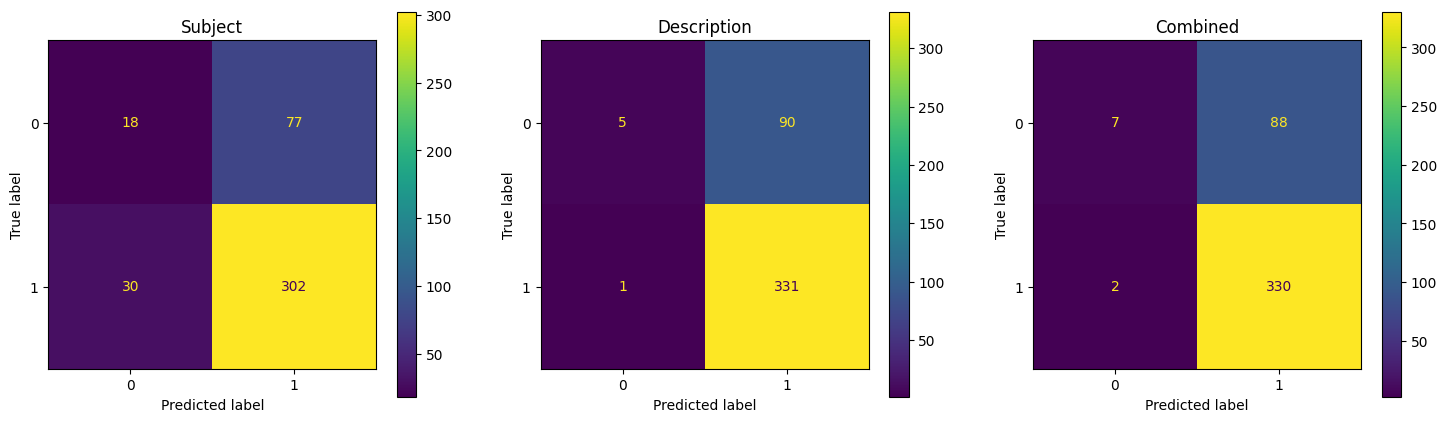

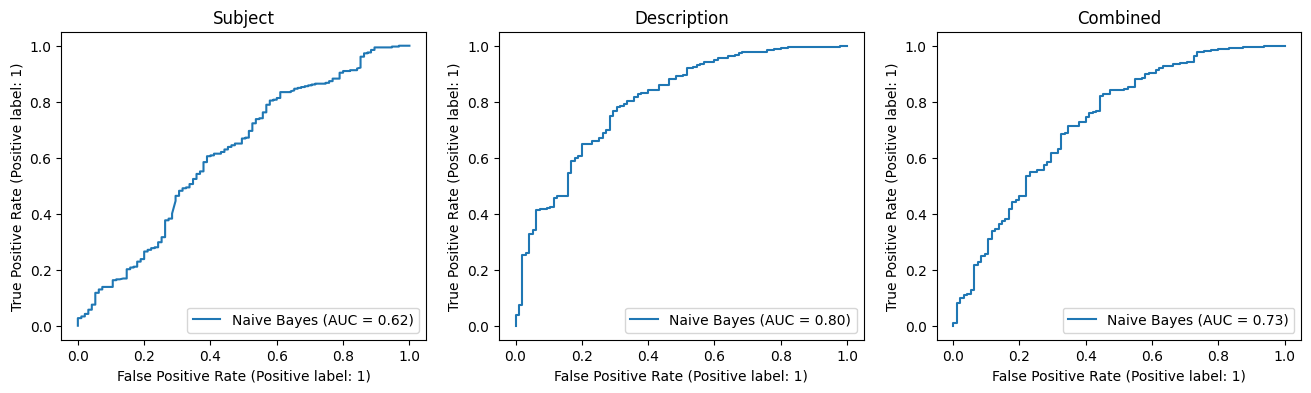


FITTING LOGISTIC REGRESSION CLASSIFIER TO CATEGORY:  objective

Subject accuracy: 0.7306791569086651
Subject AUC score: 0.6798351299936589
Subject precision, recall, f1 score: (0.8557377049180328, 0.786144578313253, 0.8194662480376766)

Description accuracy: 0.7939110070257611
Description AUC score: 0.8298034242232087
Description precision, recall, f1 score: (0.8765432098765432, 0.8554216867469879, 0.8658536585365854)

Combined accuracy: 0.8126463700234192
Combined AUC score: 0.7977488902980342
Combined precision, recall, f1 score: (0.8795180722891566, 0.8795180722891566, 0.8795180722891566)



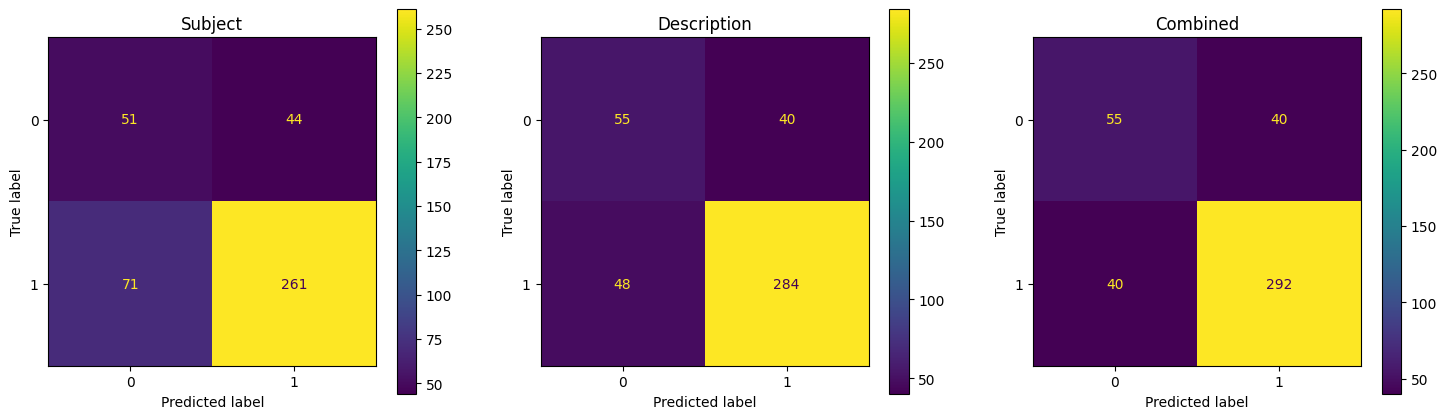

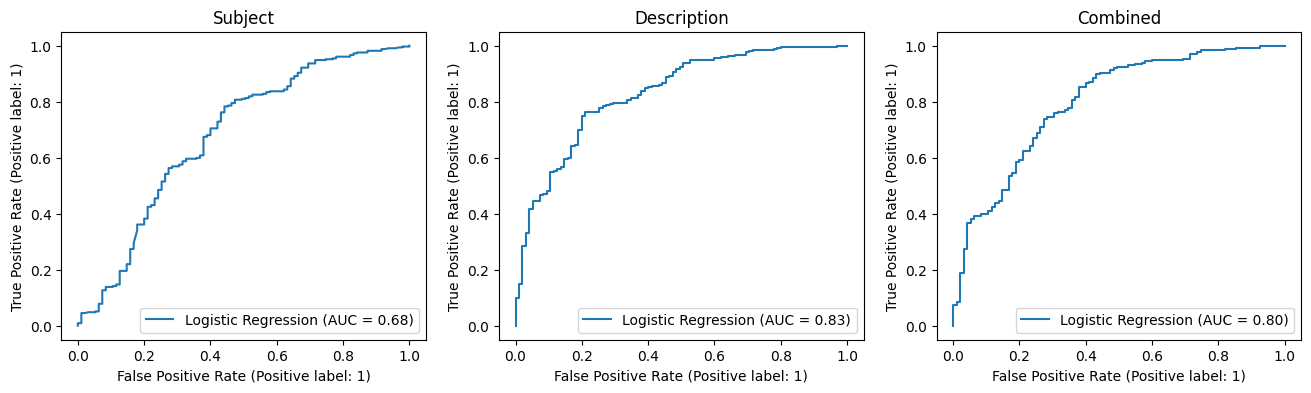


FITTING RANDOM FOREST CLASSIFIER TO CATEGORY:  objective

Subject accuracy: 0.7798594847775175
Subject AUC score: 0.7085288522511098
Subject precision, recall, f1 score: (0.8051282051282052, 0.9457831325301205, 0.8698060941828255)

Description accuracy: 0.8477751756440282
Description AUC score: 0.8323557387444516
Description precision, recall, f1 score: (0.8637602179836512, 0.9548192771084337, 0.9070100143061517)

Combined accuracy: 0.819672131147541
Combined AUC score: 0.8238902980342423
Combined precision, recall, f1 score: (0.8211586901763224, 0.9819277108433735, 0.8943758573388203)



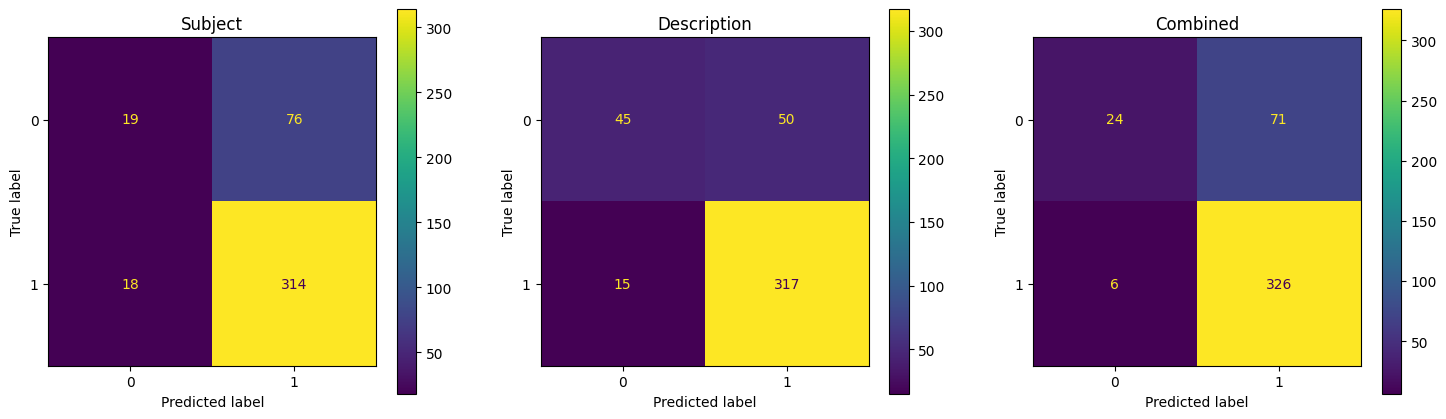

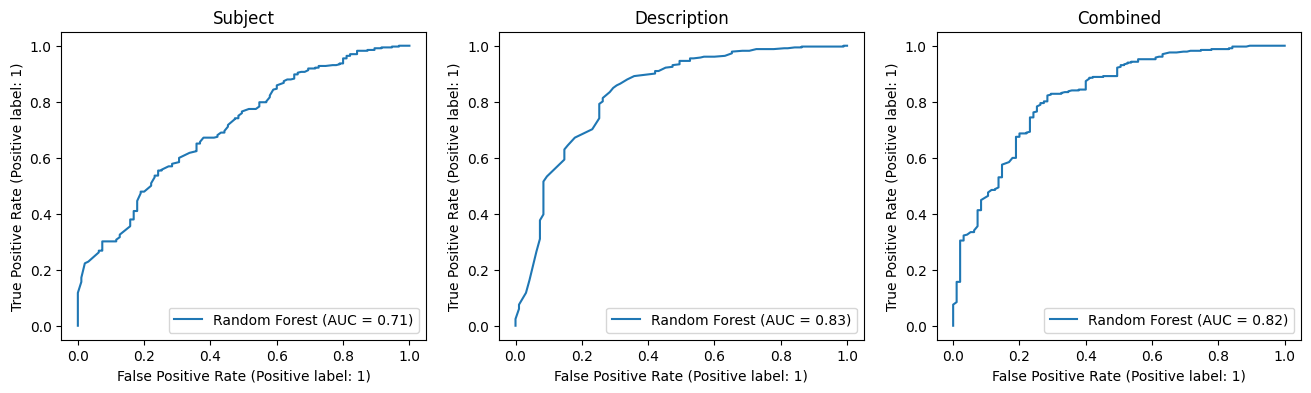


FITTING SUPPORT VECTOR CLASSIFIER TO CATEGORY:  objective

Subject accuracy: 0.7892271662763466
Subject AUC score: 0.6921686746987952
Subject precision, recall, f1 score: (0.8342541436464088, 0.9096385542168675, 0.8703170028818443)

Description accuracy: 0.8290398126463701
Description AUC score: 0.8224159797083069
Description precision, recall, f1 score: (0.8471849865951743, 0.9518072289156626, 0.8964539007092198)

Combined accuracy: 0.8220140515222483
Combined AUC score: 0.8056753329105896
Combined precision, recall, f1 score: (0.8298969072164949, 0.9698795180722891, 0.8944444444444445)



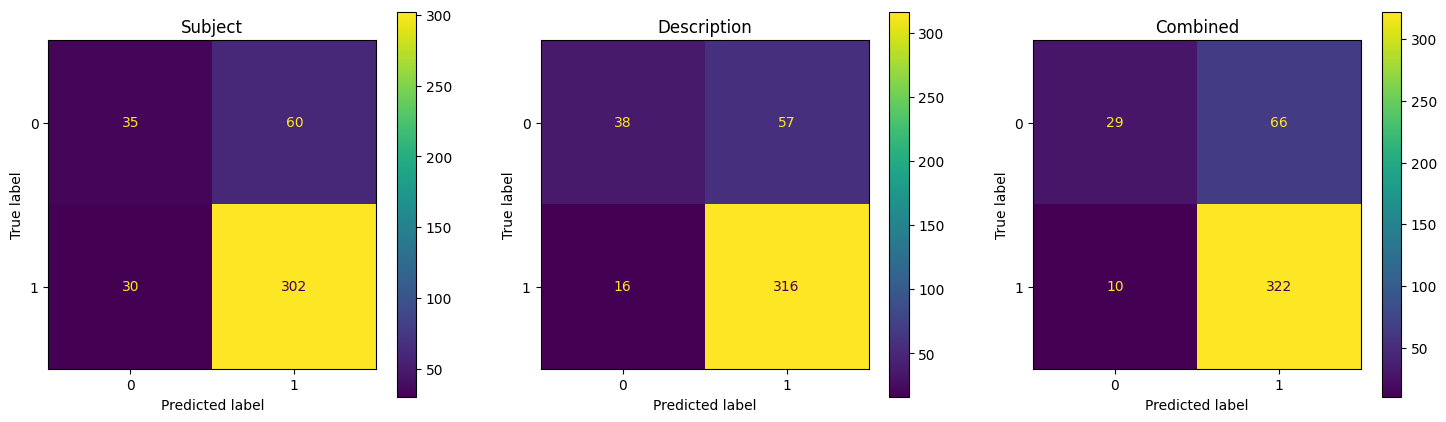

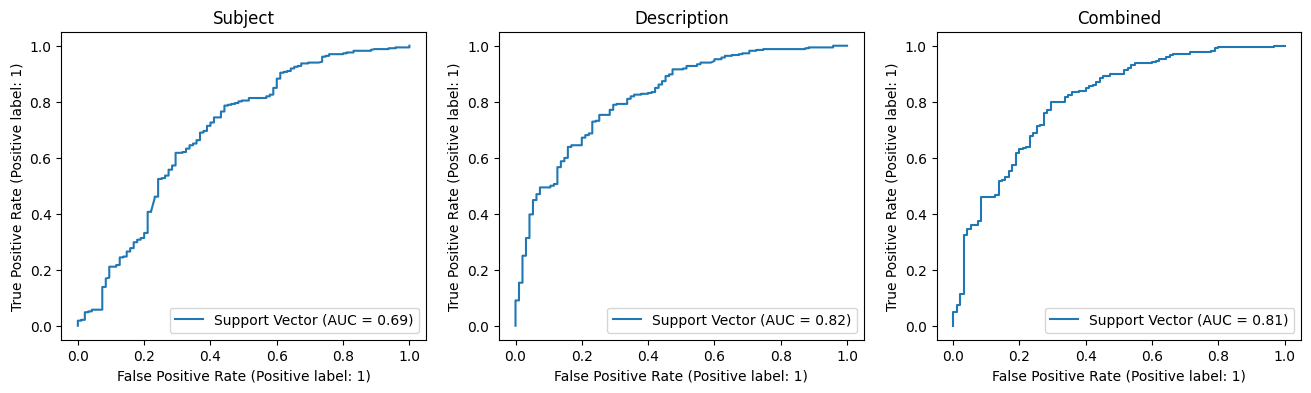


*** FITTING CATEOGROY:  quality  ***


FITTING NAIVE BAYES CLASSIFIER TO CATEGORY:  quality

Subject accuracy: 0.6112412177985949
Subject AUC score: 0.6730066481750538
Subject precision, recall, f1 score: (0.6442307692307693, 0.5929203539823009, 0.6175115207373272)

Description accuracy: 0.6814988290398126
Description AUC score: 0.8069607713644167
Description precision, recall, f1 score: (0.6371951219512195, 0.9247787610619469, 0.7545126353790613)

Combined accuracy: 0.6932084309133489
Combined AUC score: 0.7692951173336857
Combined precision, recall, f1 score: (0.6588628762541806, 0.8716814159292036, 0.7504761904761905)



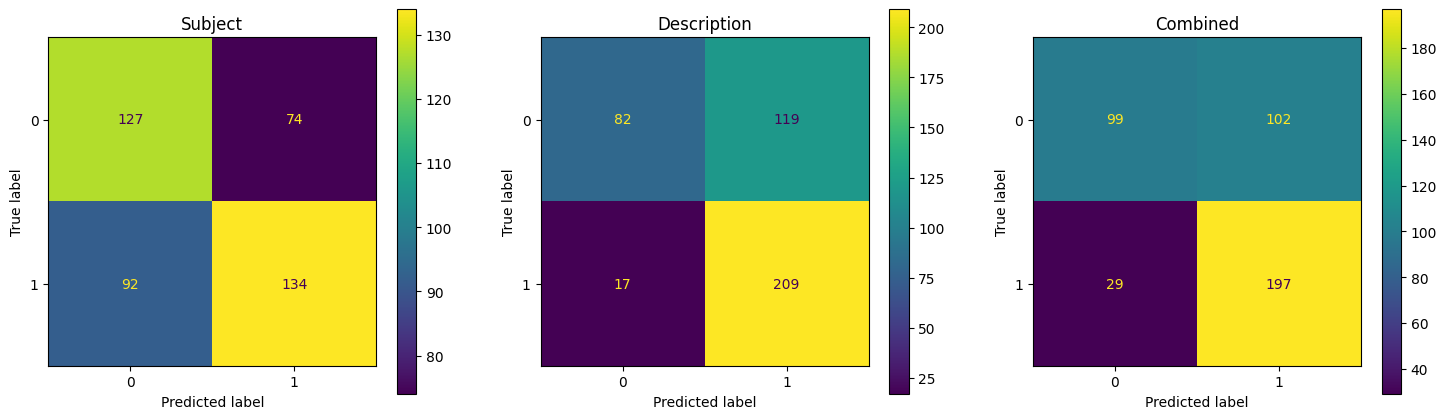

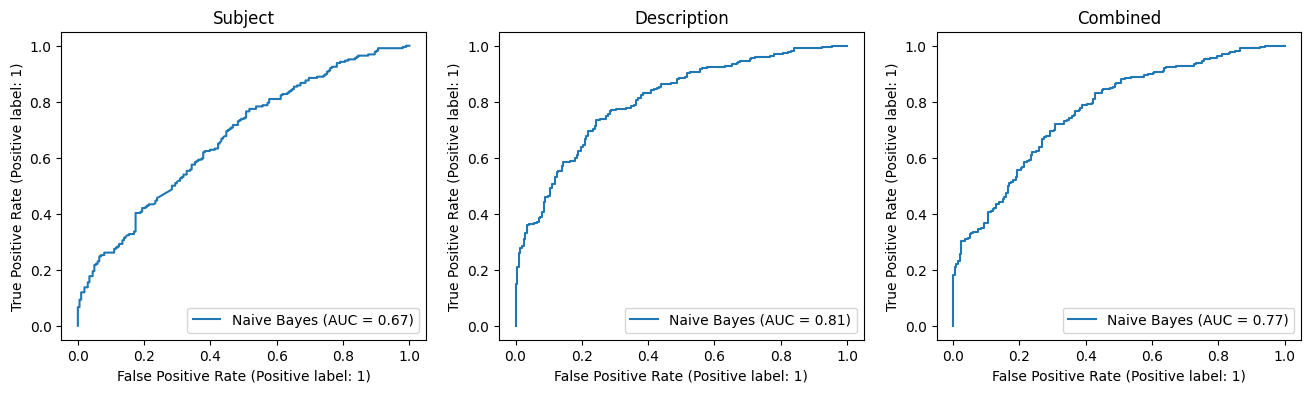


FITTING LOGISTIC REGRESSION CLASSIFIER TO CATEGORY:  quality

Subject accuracy: 0.6252927400468384
Subject AUC score: 0.6684938141152643
Subject precision, recall, f1 score: (0.6527777777777778, 0.6238938053097345, 0.6380090497737556)

Description accuracy: 0.7236533957845434
Description AUC score: 0.8038568220842689
Description precision, recall, f1 score: (0.725, 0.7699115044247787, 0.7467811158798284)

Combined accuracy: 0.702576112412178
Combined AUC score: 0.7712103200810108
Combined precision, recall, f1 score: (0.7088607594936709, 0.7433628318584071, 0.7257019438444924)



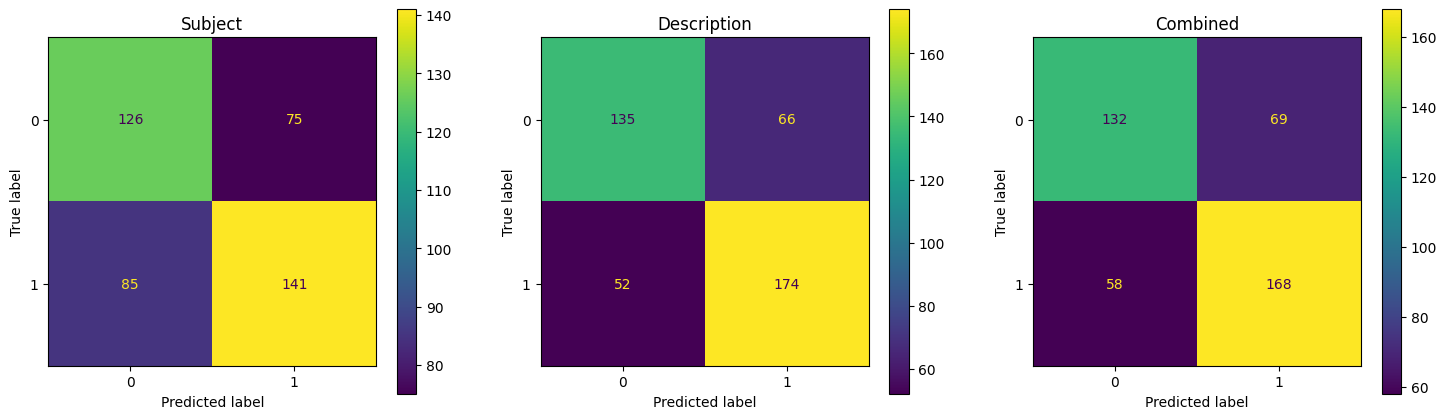

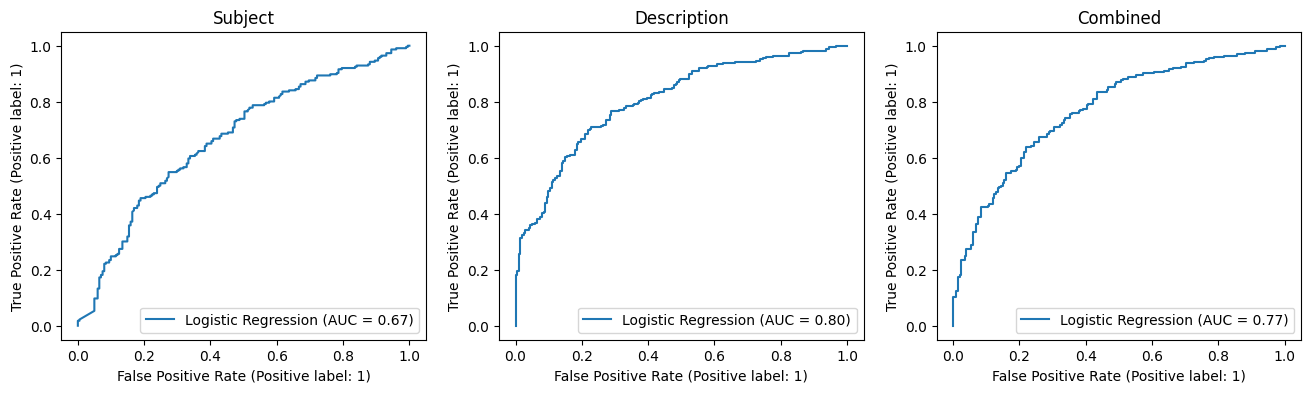


FITTING RANDOM FOREST CLASSIFIER TO CATEGORY:  quality

Subject accuracy: 0.6416861826697893
Subject AUC score: 0.6979813322766698
Subject precision, recall, f1 score: (0.6697674418604651, 0.6371681415929203, 0.653061224489796)

Description accuracy: 0.747072599531616
Description AUC score: 0.8215779509531986
Description precision, recall, f1 score: (0.743801652892562, 0.7964601769911505, 0.7692307692307692)

Combined accuracy: 0.7049180327868853
Combined AUC score: 0.7842535112050368
Combined precision, recall, f1 score: (0.7083333333333334, 0.7522123893805309, 0.7296137339055794)



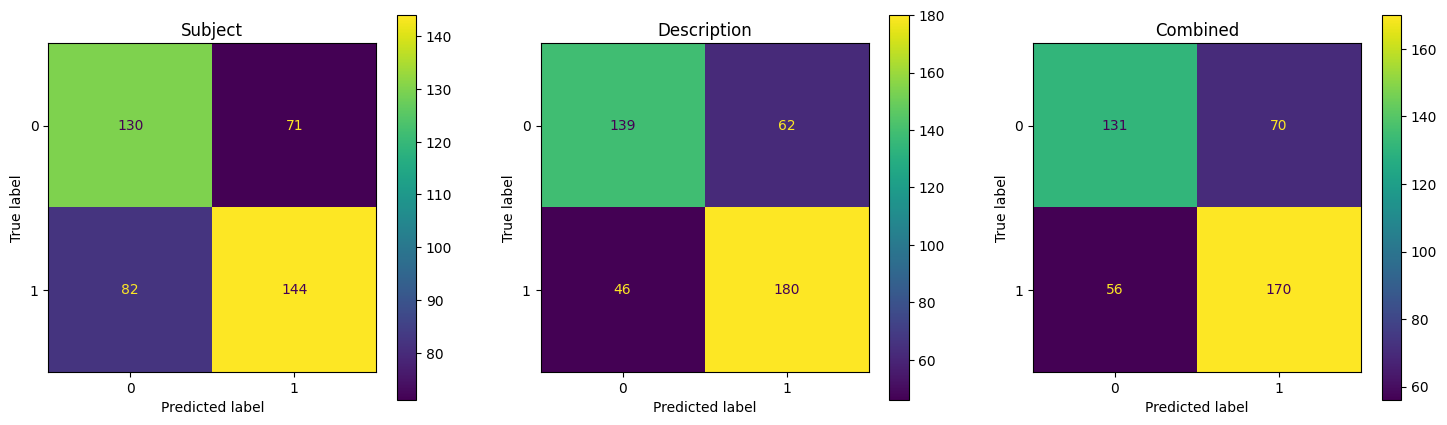

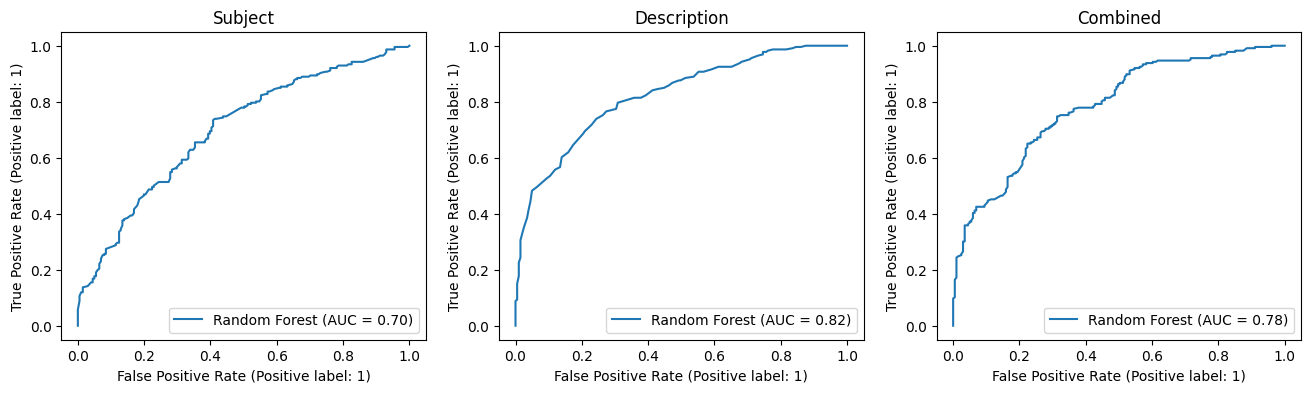


FITTING SUPPORT VECTOR CLASSIFIER TO CATEGORY:  quality

Subject accuracy: 0.629976580796253
Subject AUC score: 0.6814709637652446
Subject precision, recall, f1 score: (0.6491228070175439, 0.6548672566371682, 0.6519823788546256)

Description accuracy: 0.7189695550351288
Description AUC score: 0.8098665962224276
Description precision, recall, f1 score: (0.7172131147540983, 0.7743362831858407, 0.7446808510638298)

Combined accuracy: 0.7049180327868853
Combined AUC score: 0.7849909743318804
Combined precision, recall, f1 score: (0.7066115702479339, 0.7566371681415929, 0.7307692307692308)



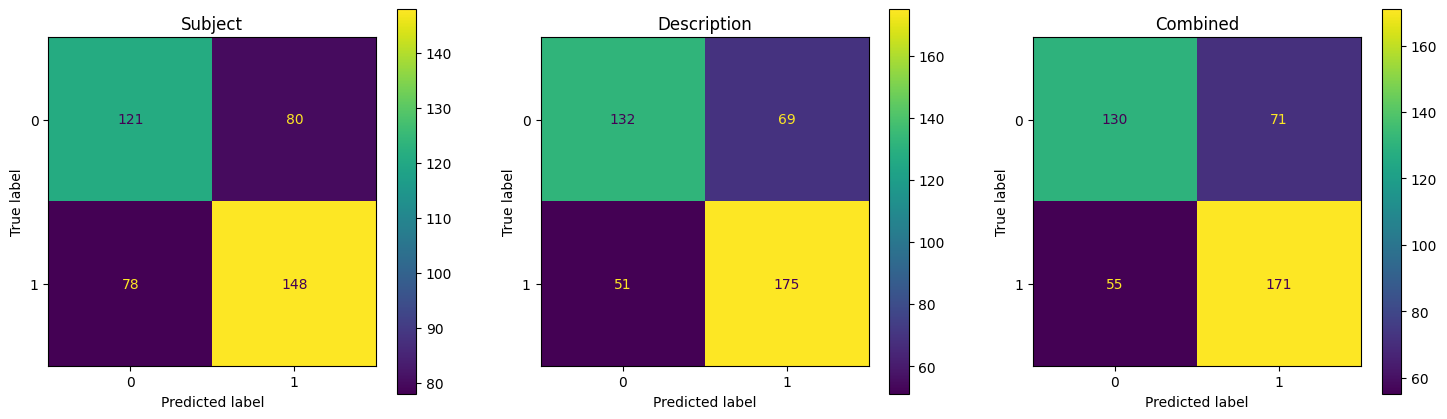

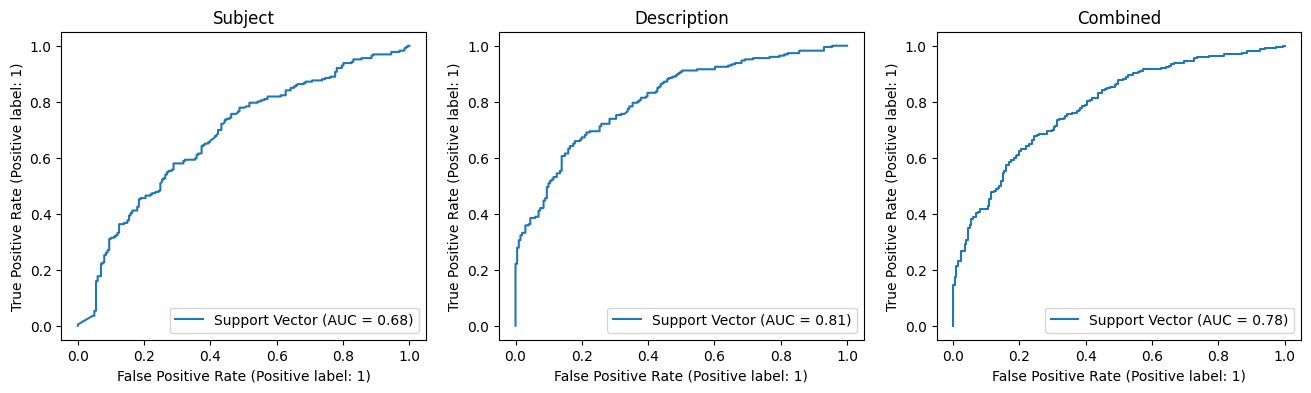


*** FITTING CATEOGROY:  testing  ***


FITTING NAIVE BAYES CLASSIFIER TO CATEGORY:  testing

Subject accuracy: 0.7517564402810304
Subject AUC score: 0.8283306829225197
Subject precision, recall, f1 score: (0.7227722772277227, 0.7448979591836735, 0.7336683417085428)

Description accuracy: 0.8032786885245902
Description AUC score: 0.89937273610743
Description precision, recall, f1 score: (0.8733333333333333, 0.6683673469387755, 0.7572254335260116)

Combined accuracy: 0.8149882903981265
Combined AUC score: 0.8882410106899902
Combined precision, recall, f1 score: (0.8268156424581006, 0.7551020408163265, 0.7893333333333333)



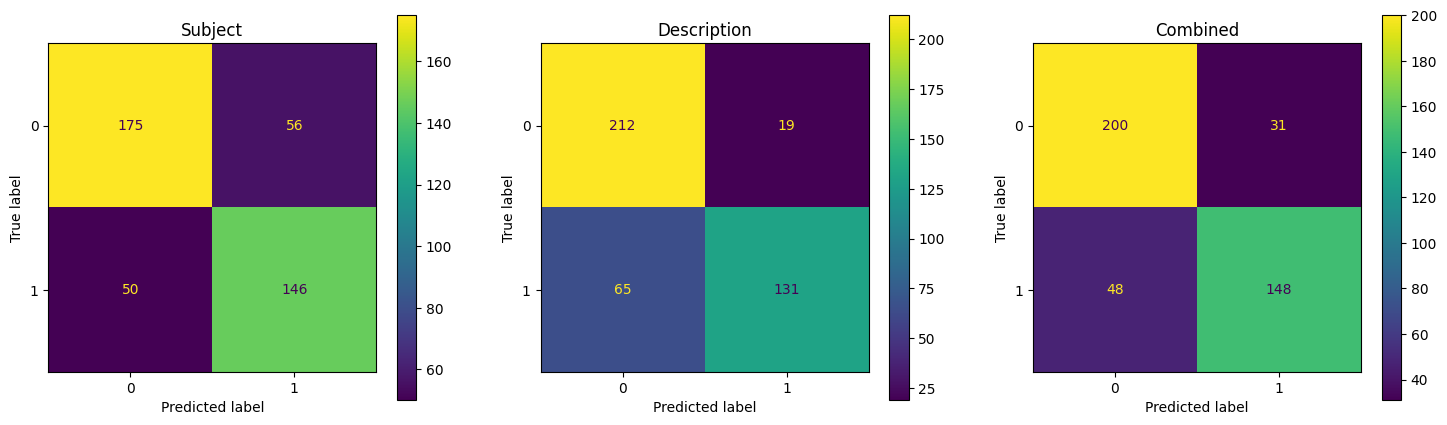

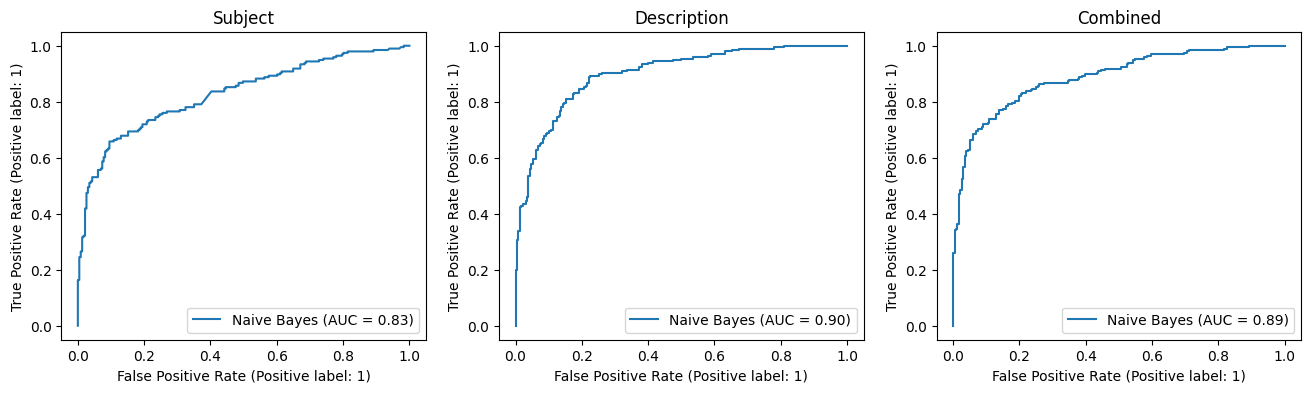


FITTING LOGISTIC REGRESSION CLASSIFIER TO CATEGORY:  testing

Subject accuracy: 0.810304449648712
Subject AUC score: 0.8441227140206733
Subject precision, recall, f1 score: (0.8807947019867549, 0.6785714285714286, 0.7665706051873198)

Description accuracy: 0.9086651053864169
Description AUC score: 0.9535294637335453
Description precision, recall, f1 score: (0.9385474860335196, 0.8571428571428571, 0.8959999999999999)

Combined accuracy: 0.8758782201405152
Combined AUC score: 0.9371631769590953
Combined precision, recall, f1 score: (0.9333333333333333, 0.7857142857142857, 0.8531855955678669)



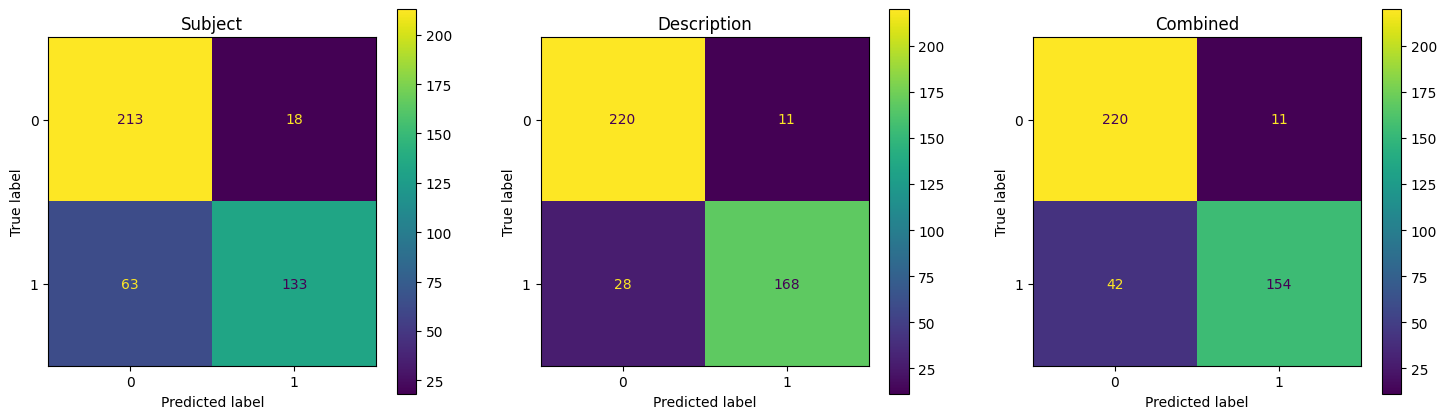

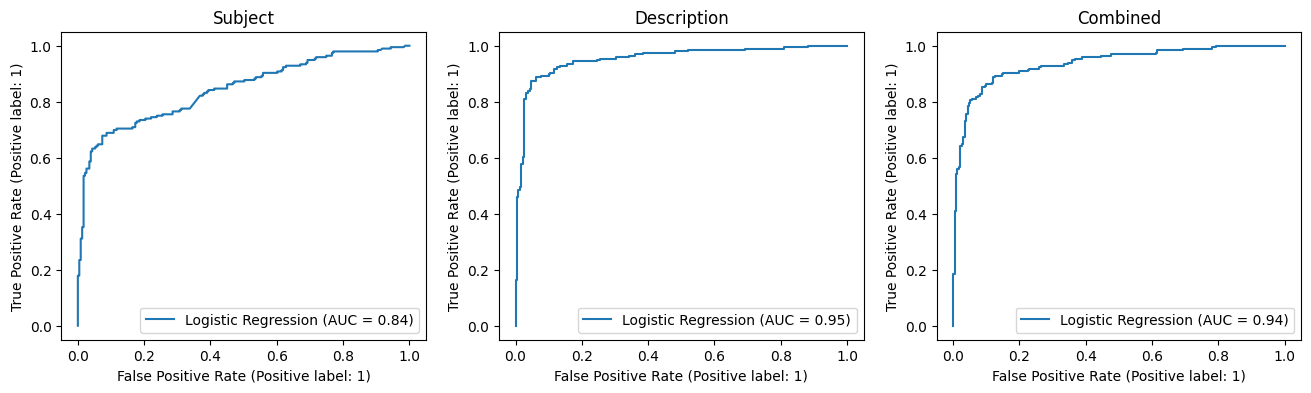


FITTING RANDOM FOREST CLASSIFIER TO CATEGORY:  testing

Subject accuracy: 0.7962529274004684
Subject AUC score: 0.857352681332273
Subject precision, recall, f1 score: (0.8562091503267973, 0.6683673469387755, 0.7507163323782234)

Description accuracy: 0.8852459016393442
Description AUC score: 0.9560694407633182
Description precision, recall, f1 score: (0.9349112426035503, 0.8061224489795918, 0.8657534246575342)

Combined accuracy: 0.8407494145199064
Combined AUC score: 0.9398798480431134
Combined precision, recall, f1 score: (0.9155844155844156, 0.7193877551020408, 0.8057142857142857)



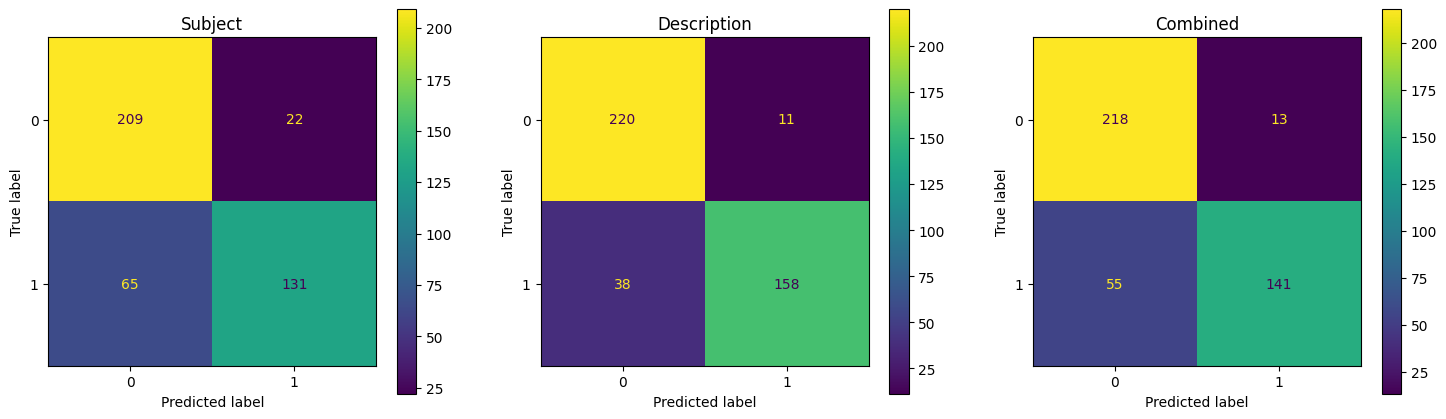

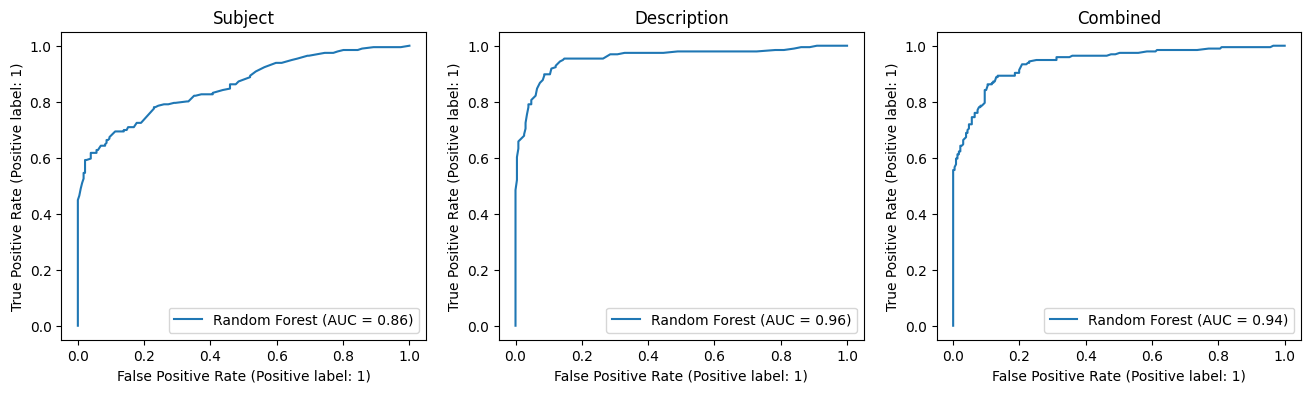


FITTING SUPPORT VECTOR CLASSIFIER TO CATEGORY:  testing

Subject accuracy: 0.810304449648712
Subject AUC score: 0.8425766410460288
Subject precision, recall, f1 score: (0.896551724137931, 0.6632653061224489, 0.7624633431085044)

Description accuracy: 0.8946135831381733
Description AUC score: 0.9512103542715789
Description precision, recall, f1 score: (0.9631901840490797, 0.8010204081632653, 0.8746518105849581)

Combined accuracy: 0.8969555035128806
Combined AUC score: 0.941713048855906
Combined precision, recall, f1 score: (0.9269662921348315, 0.8418367346938775, 0.8823529411764706)



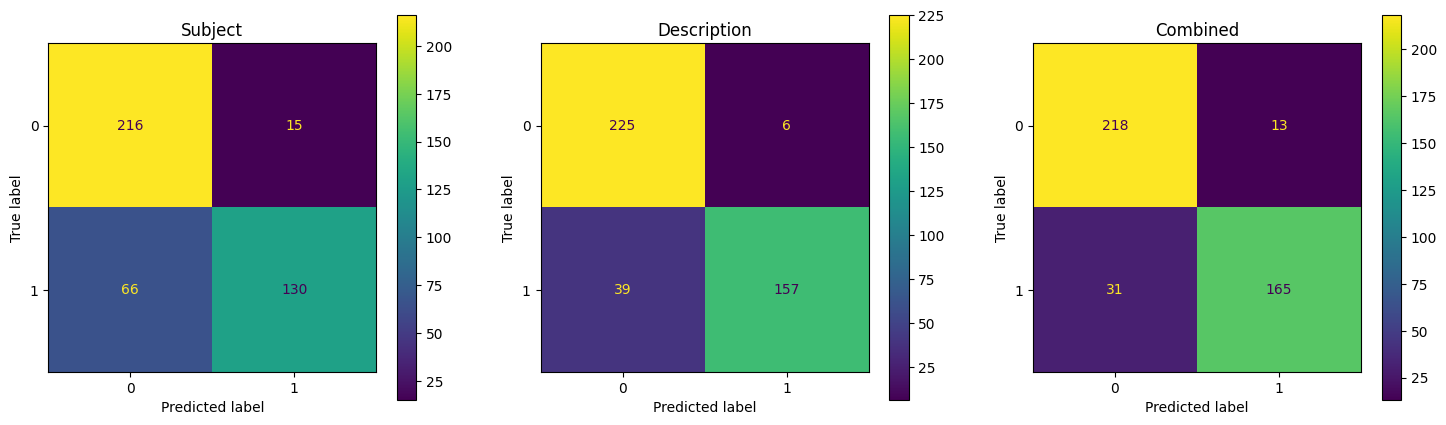

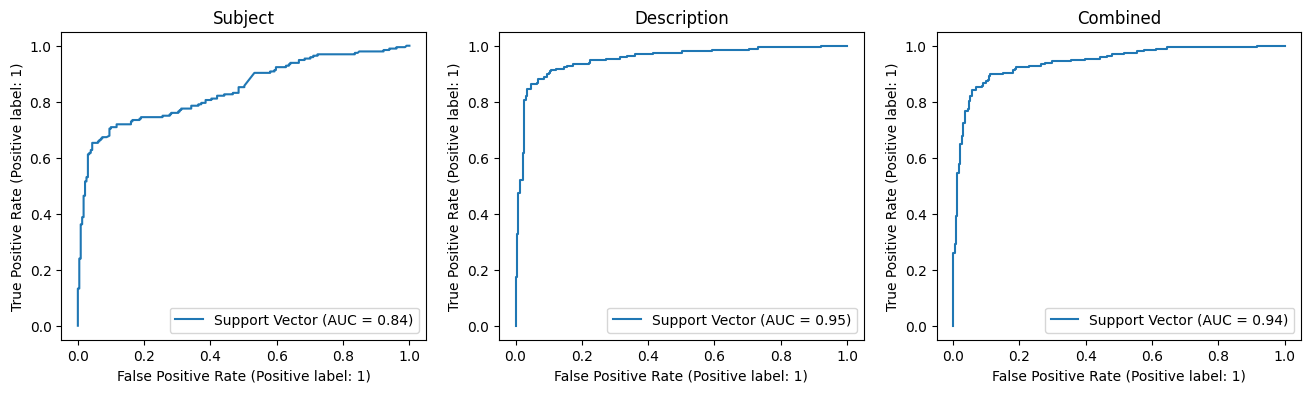


*** FITTING CATEOGROY:  integration  ***


FITTING NAIVE BAYES CLASSIFIER TO CATEGORY:  integration

Subject accuracy: 0.8056206088992974
Subject AUC score: 0.8167769506479183
Subject precision, recall, f1 score: (0.6808510638297872, 0.5470085470085471, 0.6066350710900476)

Description accuracy: 0.747072599531616
Description AUC score: 0.7947615108905433
Description precision, recall, f1 score: (0.9090909090909091, 0.08547008547008547, 0.15625)

Combined accuracy: 0.7868852459016393
Combined AUC score: 0.8432864626413015
Combined precision, recall, f1 score: (0.8823529411764706, 0.2564102564102564, 0.3973509933774834)



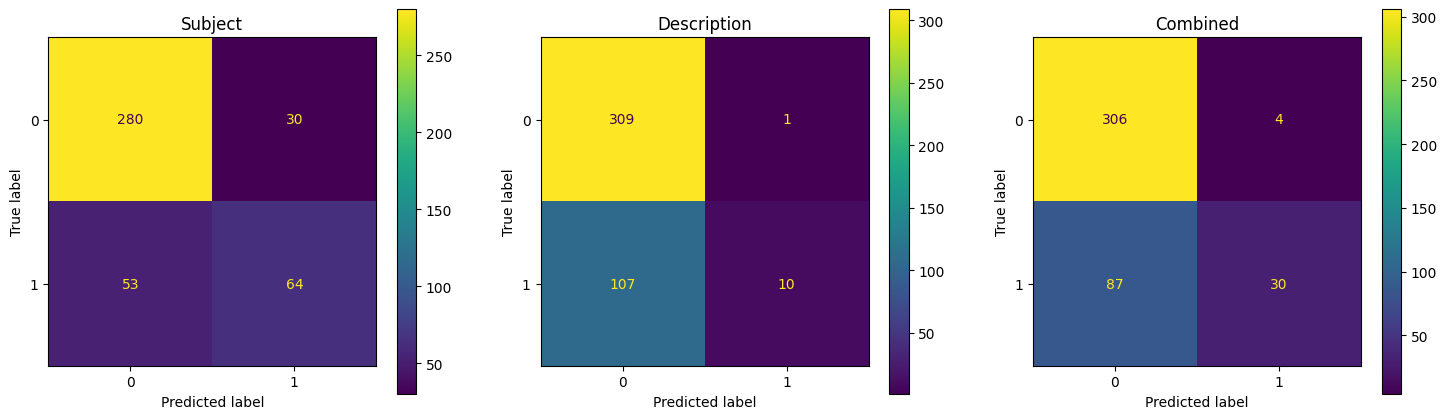

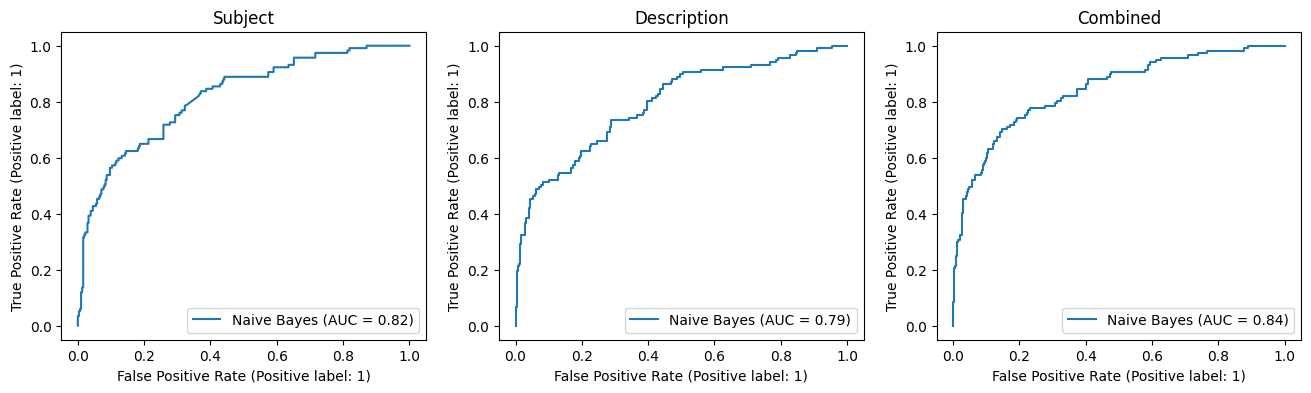


FITTING LOGISTIC REGRESSION CLASSIFIER TO CATEGORY:  integration

Subject accuracy: 0.8384074941451991
Subject AUC score: 0.8485938792390406
Subject precision, recall, f1 score: (0.7448979591836735, 0.6239316239316239, 0.6790697674418604)

Description accuracy: 0.8969555035128806
Description AUC score: 0.9448855803694514
Description precision, recall, f1 score: (0.8543689320388349, 0.7521367521367521, 0.7999999999999999)

Combined accuracy: 0.8782201405152225
Combined AUC score: 0.9426523297491041
Combined precision, recall, f1 score: (0.8494623655913979, 0.6752136752136753, 0.7523809523809524)



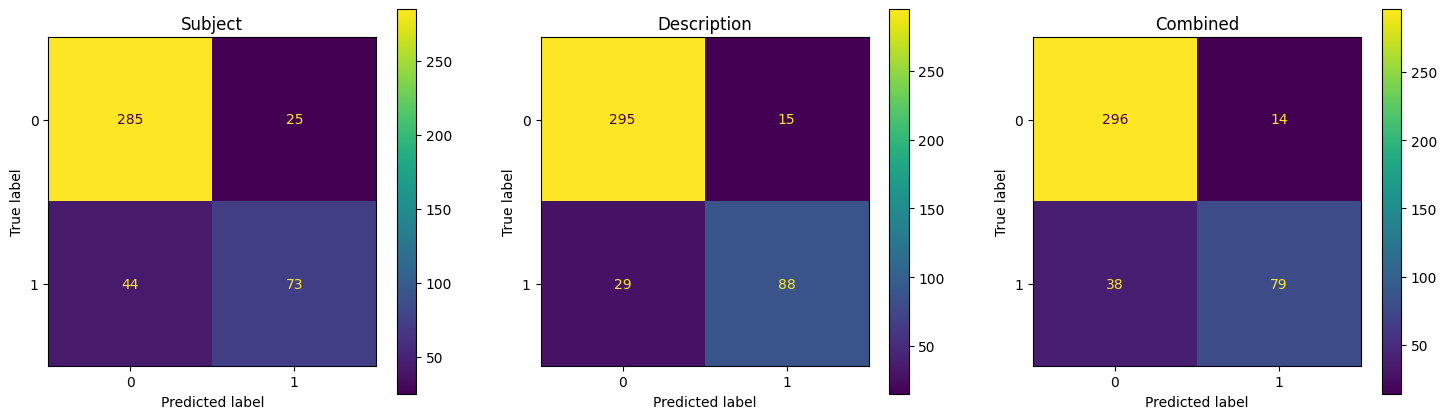

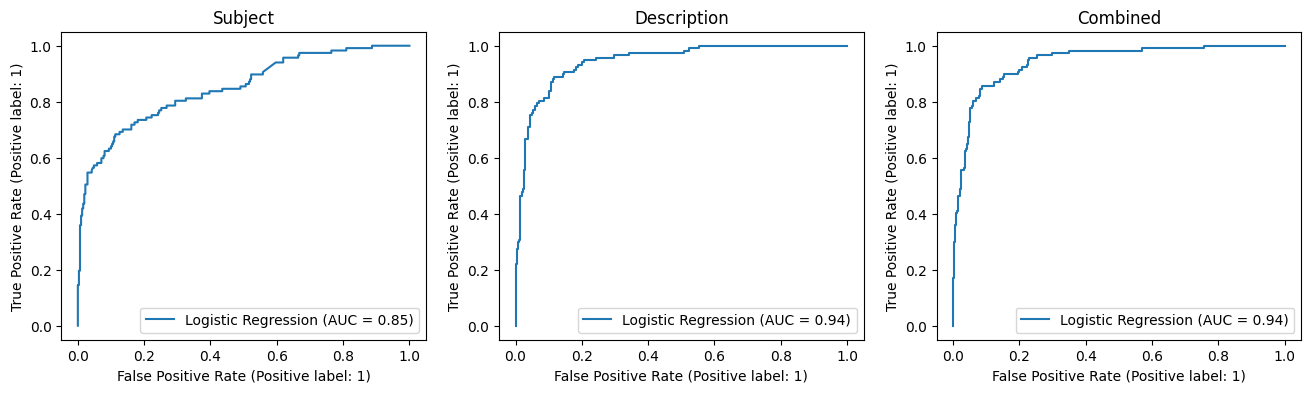


FITTING RANDOM FOREST CLASSIFIER TO CATEGORY:  integration

Subject accuracy: 0.8454332552693209
Subject AUC score: 0.8210228839261098
Subject precision, recall, f1 score: (0.9047619047619048, 0.48717948717948717, 0.6333333333333333)

Description accuracy: 0.8149882903981265
Description AUC score: 0.9297353184449959
Description precision, recall, f1 score: (0.8958333333333334, 0.36752136752136755, 0.5212121212121211)

Combined accuracy: 0.8360655737704918
Combined AUC score: 0.922070581748001
Combined precision, recall, f1 score: (0.9607843137254902, 0.4188034188034188, 0.5833333333333334)



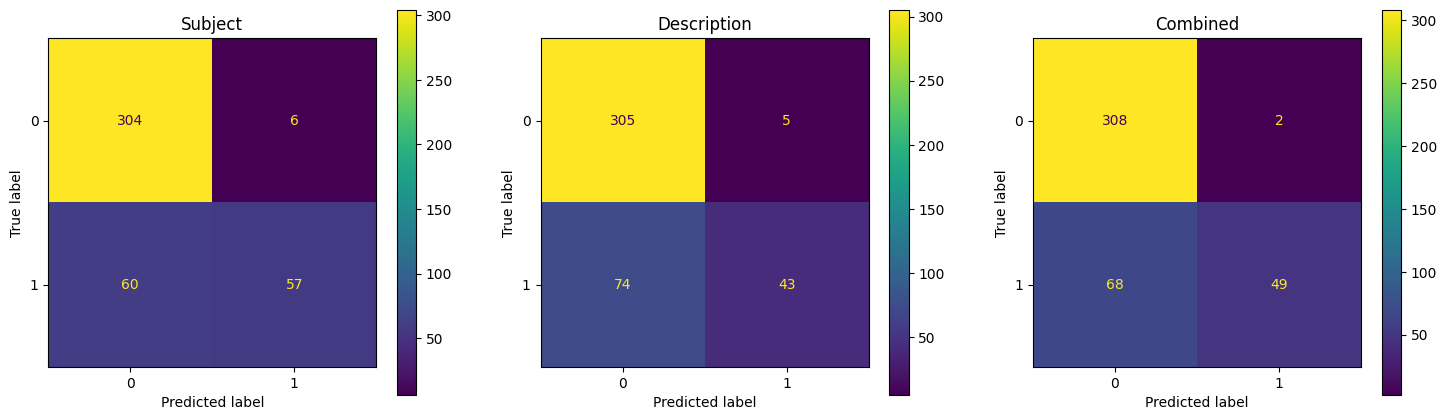

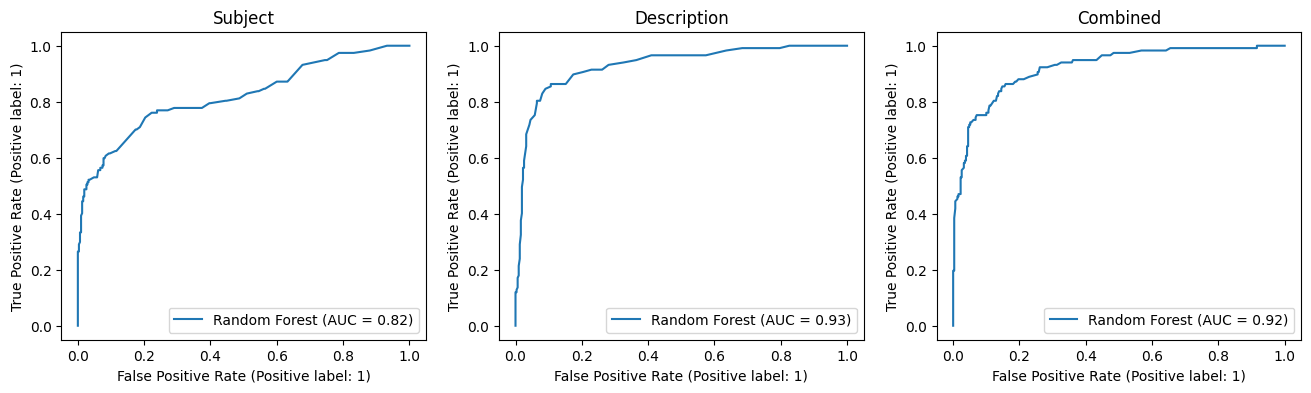


FITTING SUPPORT VECTOR CLASSIFIER TO CATEGORY:  integration

Subject accuracy: 0.8430913348946136
Subject AUC score: 0.8506065618968844
Subject precision, recall, f1 score: (0.8205128205128205, 0.5470085470085471, 0.6564102564102564)

Description accuracy: 0.8735362997658079
Description AUC score: 0.9471739729804246
Description precision, recall, f1 score: (0.8888888888888888, 0.6153846153846154, 0.7272727272727274)

Combined accuracy: 0.8735362997658079
Combined AUC score: 0.943065894678798
Combined precision, recall, f1 score: (0.8539325842696629, 0.6495726495726496, 0.7378640776699029)



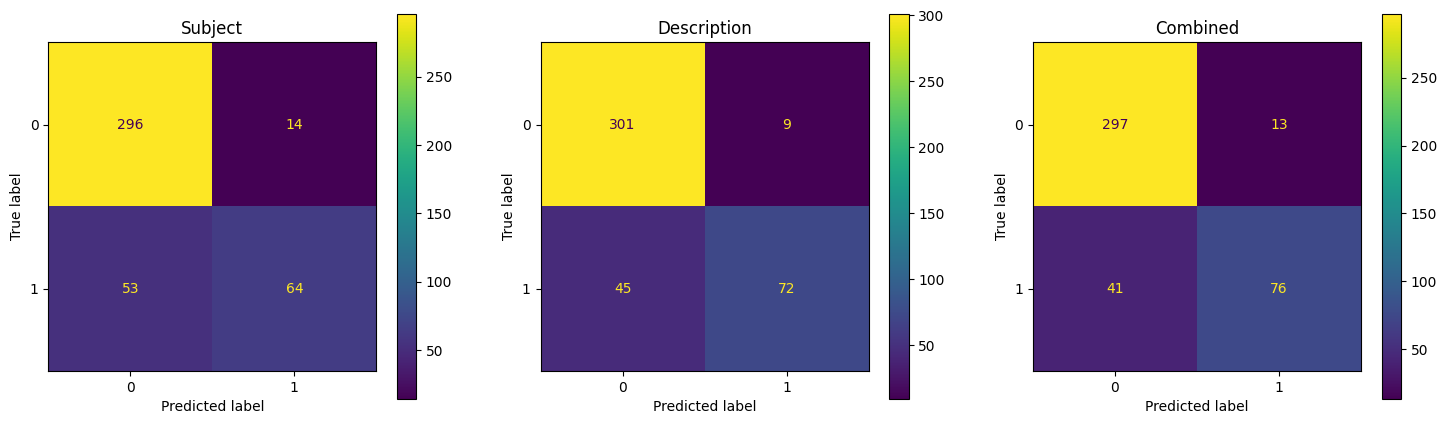

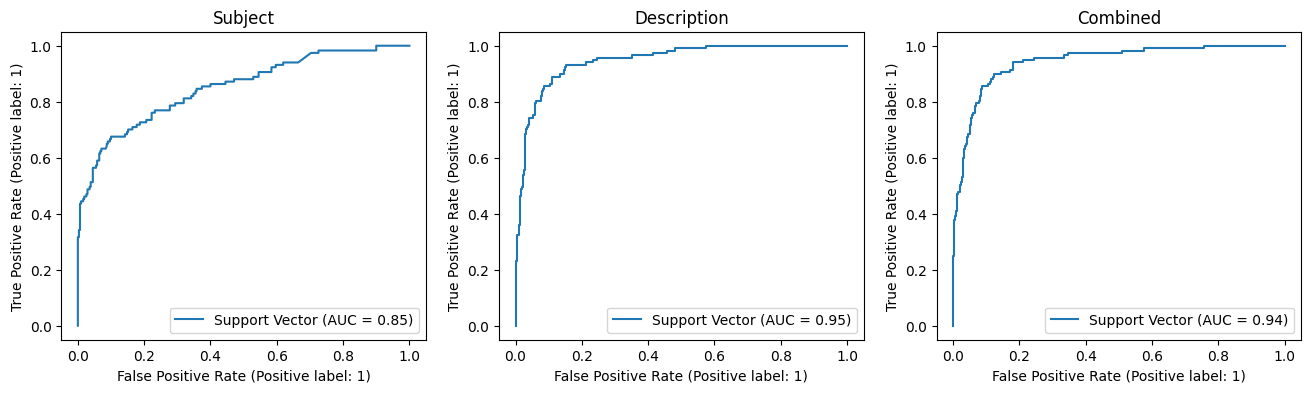


*** FITTING CATEOGROY:  refactoring  ***


FITTING NAIVE BAYES CLASSIFIER TO CATEGORY:  refactoring

Subject accuracy: 0.8875878220140515
Subject AUC score: 0.754296726905093
Subject precision, recall, f1 score: (0.3939393939393939, 0.3170731707317073, 0.35135135135135137)

Description accuracy: 0.9063231850117096
Description AUC score: 0.8309427524327057
Description precision, recall, f1 score: (1.0, 0.024390243902439025, 0.047619047619047616)

Combined accuracy: 0.9110070257611241
Combined AUC score: 0.8172943257929989
Combined precision, recall, f1 score: (1.0, 0.07317073170731707, 0.13636363636363635)



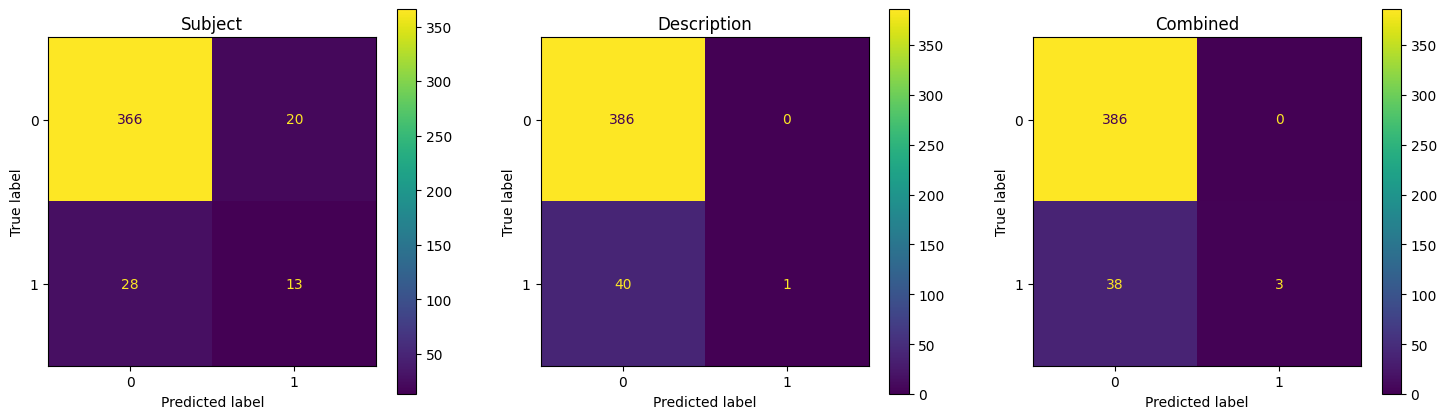

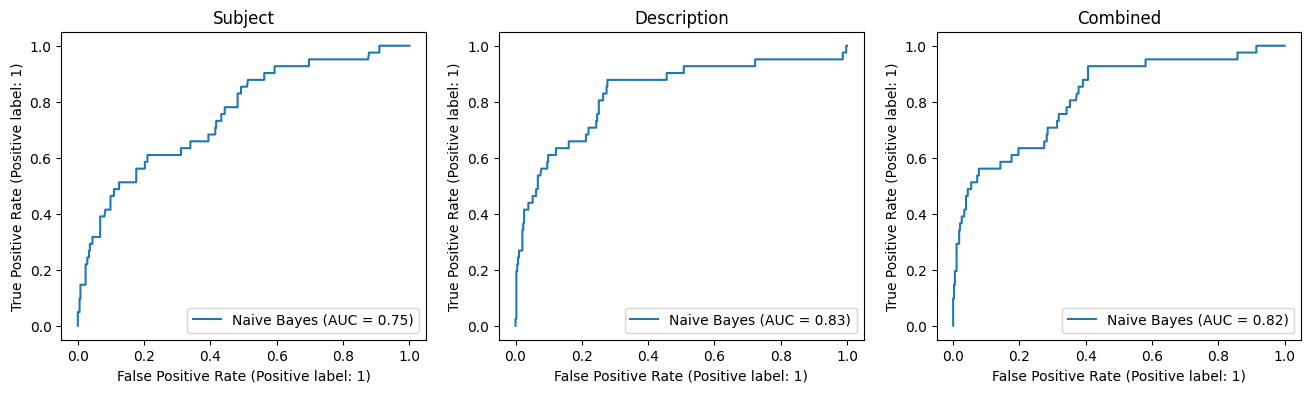


FITTING LOGISTIC REGRESSION CLASSIFIER TO CATEGORY:  refactoring

Subject accuracy: 0.8758782201405152
Subject AUC score: 0.8268355870087198
Subject precision, recall, f1 score: (0.4, 0.5853658536585366, 0.4752475247524752)

Description accuracy: 0.9344262295081968
Description AUC score: 0.9100530772147098
Description precision, recall, f1 score: (0.6666666666666666, 0.6341463414634146, 0.6499999999999999)

Combined accuracy: 0.9227166276346604
Combined AUC score: 0.901017313281941
Combined precision, recall, f1 score: (0.5952380952380952, 0.6097560975609756, 0.6024096385542169)



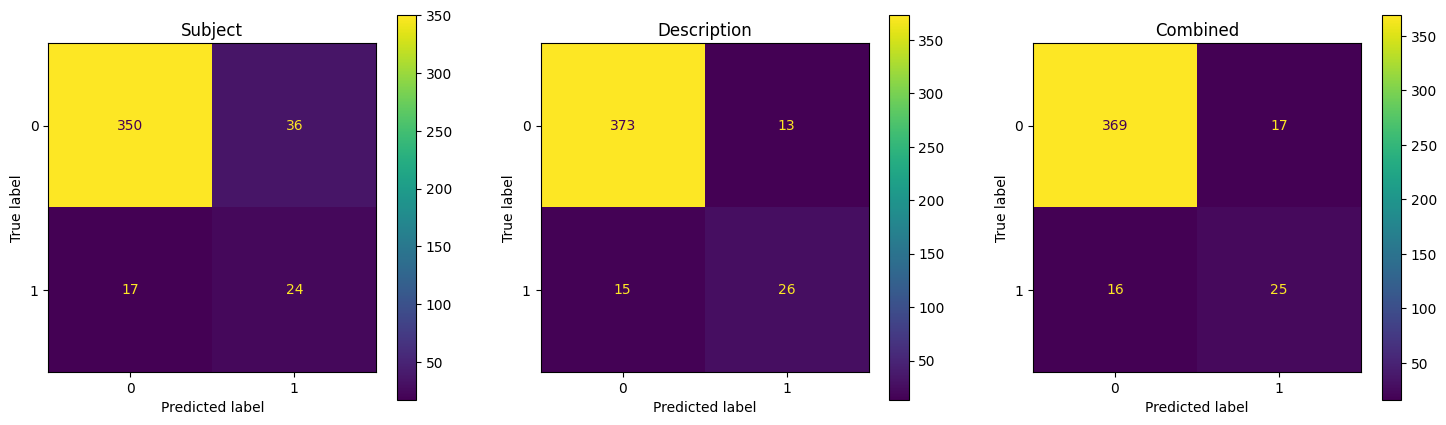

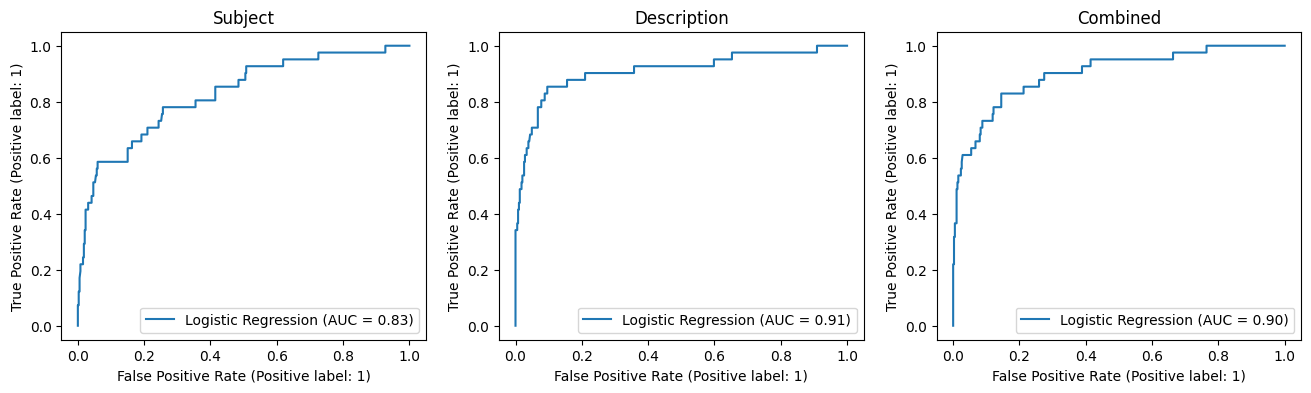


FITTING RANDOM FOREST CLASSIFIER TO CATEGORY:  refactoring

Subject accuracy: 0.9156908665105387
Subject AUC score: 0.7933463920131428
Subject precision, recall, f1 score: (0.7777777777777778, 0.17073170731707318, 0.27999999999999997)

Description accuracy: 0.9133489461358314
Description AUC score: 0.8941615063819033
Description precision, recall, f1 score: (0.8333333333333334, 0.12195121951219512, 0.21276595744680848)

Combined accuracy: 0.9156908665105387
Combined AUC score: 0.9061670668520156
Combined precision, recall, f1 score: (0.7777777777777778, 0.17073170731707318, 0.27999999999999997)



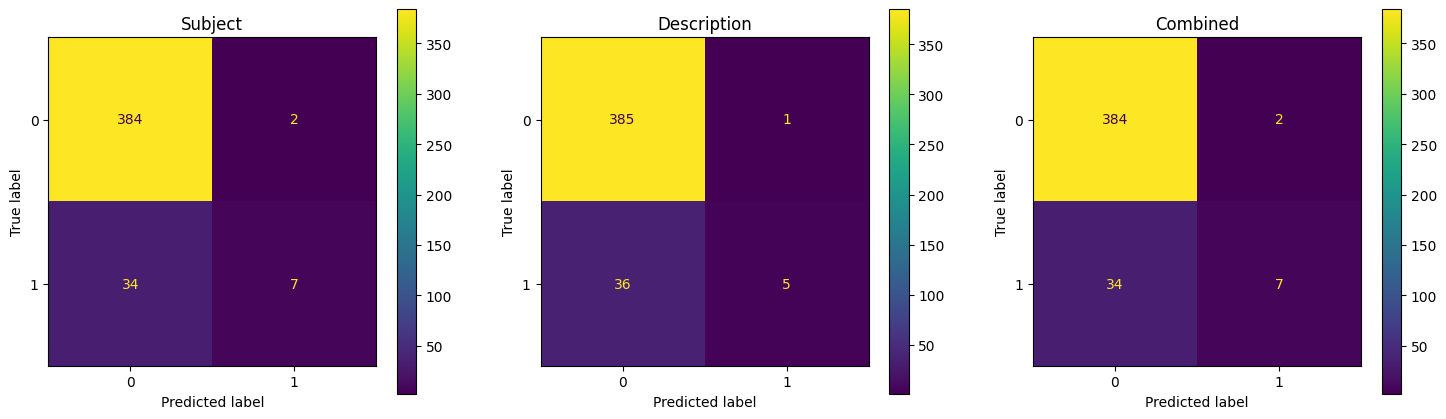

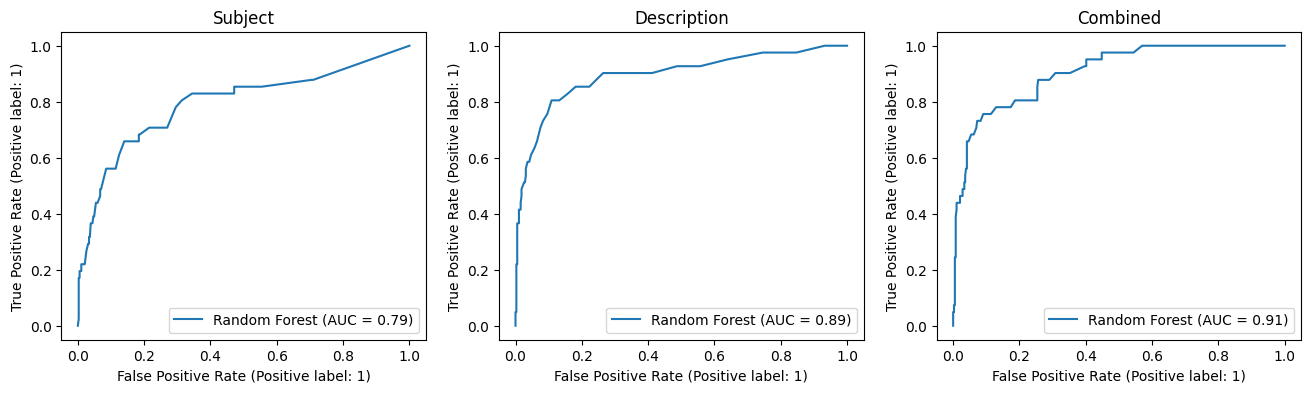


FITTING SUPPORT VECTOR CLASSIFIER TO CATEGORY:  refactoring

Subject accuracy: 0.9156908665105387
Subject AUC score: 0.832964741564514
Subject precision, recall, f1 score: (0.6470588235294118, 0.2682926829268293, 0.3793103448275862)

Description accuracy: 0.9227166276346604
Description AUC score: 0.9036711740174397
Description precision, recall, f1 score: (0.8333333333333334, 0.24390243902439024, 0.37735849056603776)

Combined accuracy: 0.9320843091334895
Combined AUC score: 0.9056931631492481
Combined precision, recall, f1 score: (0.875, 0.34146341463414637, 0.4912280701754386)



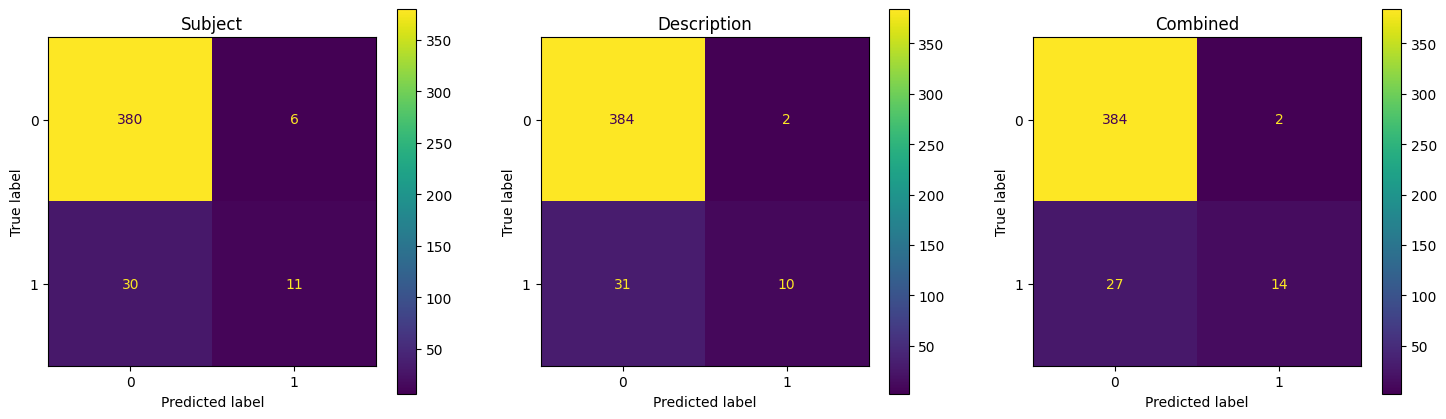

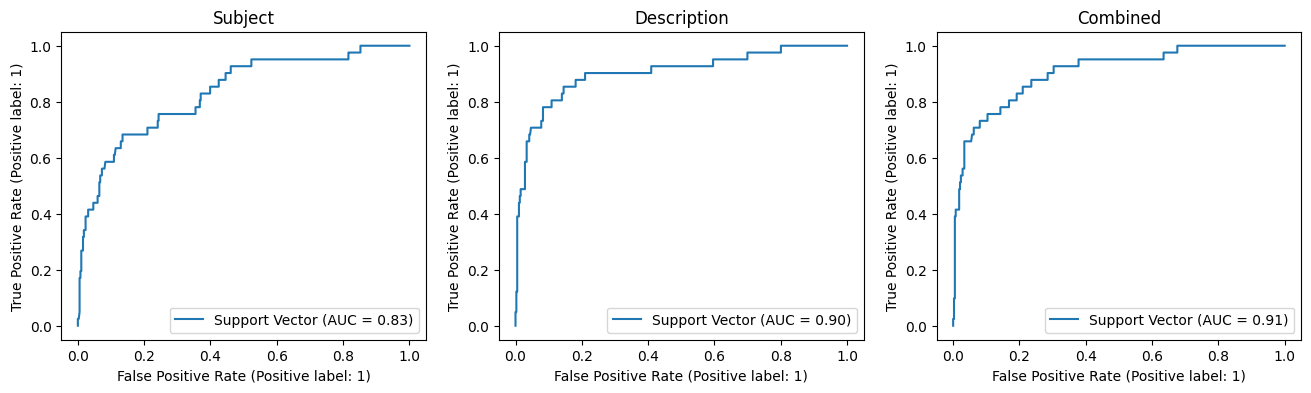

In [ ]:
categories_to_fit = ['objective','quality','testing','integration','refactoring'] #Ordered from most populated to least populated. #Only 'quality' and 'testing' are approximately balanced.

fit_everything(categories_to_fit)